In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.linalg as la 
import heapq

In [2]:
"""Function to get our dataset"""
def getImages(path):
    trainSet = list()
    testSet = list()
    y_train = list()
    y_test = list()
    for i in range(1,39):
        for j in range(1,11):
            img = cv2.imread(path+str(i)+"/"+str(j)+".pgm",-1)
            img = np.asarray(img).flatten()
            if j <= 6:
                trainSet.append(img)
                y_train.append(i)
            else:
                testSet.append(img)
                y_test.append(i)
                
    trainSet = np.asarray(trainSet)
    testSet = np.asarray(testSet)
    return trainSet,testSet,y_train,y_test

"""Function to get all the unknown faces, basically images of the last two folders"""
def getImages2(path):
    unkFace = list()
    y_test = list()
    for i in range(39,41):
        for j in range(1,11):
            img = cv2.imread(path+str(i)+"/"+str(j)+".pgm",-1)
            img = np.asarray(img).flatten()
            unkFace.append(img)
            y_test.append(-1)
                

    unkFace = np.asarray(unkFace)
    y_test = np.asarray(y_test)
    return unkFace,y_test

"""unused function to split dataset into test and train set"""
def split(data,trainSize):
    return data[:trainSize,:],data[trainSize:,:]

"""Finds the mean image"""
def getMeanImg(trainSet):
    meanImage = np.mean(trainSet,axis=0)
    return meanImage


"""Subtracts the mean image from all the images in training set"""
def averagedOut(trainSet,meanImage):
    trainSet = np.subtract(trainSet,meanImage)
    return trainSet

"""Finds the covariance matrix"""
def getCov(data):
    covMat = np.matmul(data,data.T)
    return covMat


"""Finds eignen values and eigen vectors"""
def getEigenVals(covarianceMatrix,trainSet):
    eigVals, eigVecs = la.eig(covarianceMatrix)
    return eigVecs,eigVals


"""Function that plots all the eigen faces"""
def plotter(data,k):
    fig = plt.figure(figsize = (40,20))
    axs = []
    for j in range(data.shape[0]):
        axs.append(fig.add_subplot(k+1, 4, j+1) )  
        plt.imshow(data[j].real.reshape(112,92),"gray")

"""Finds eigen faces"""
def getEigenFace(eigenVals,eigVec,trainSet,k):
    indices = heapq.nlargest(k,range(len(eigenVals)),eigenVals.take)
    eigVec2 = eigVec[indices,:]
    eigenFace = np.matmul(eigVec2,trainSet)
    return eigenFace

"""Finds and returns signatre matrix"""
def getSigMat(eigenFace,trainSet):
    sigMat = np.dot(eigenFace,trainSet.T)
    return sigMat

"""function that predicts on test set"""
def predict(testor,avg_face_vector,weights,eigen_faces,tolerance):
    y_pred = list()
    dist = list()
    for i in range(testor.shape[0]):
        testIm = (testor[i]).reshape(10304,1) - avg_face_vector.reshape(10304,1)
        testIm = np.transpose(testIm).dot(np.transpose(eigen_faces))
        index =  np.argmin(np.linalg.norm(testIm - weights.T, axis=1))
        if min(np.linalg.norm(testIm - weights.T, axis=1)) > tolerance:
            y_pred.append(-1)
        else:
            y_pred.append(y_train[index])
    return y_pred

"""Calculate accuracy of our prediction"""
def calcAcc(pred,test):
    acc = 0
    for i in range(len(test)):
        if test[i] == pred[i]:
            acc += 1
    return (acc/len(test))*100

In [3]:
"""Importing dataset and dividing it into train and test set"""
path = "Face Image Dataset_2020/s"
trainSet,testSet,y_train,y_test = getImages(path)
trainSet2 = np.copy(trainSet)
unknownFaces,y_test2 = getImages2(path)
testSet2 = np.concatenate((testSet,unknownFaces),axis = 0)
y_testn = np.concatenate((y_test,y_test2),axis = 0)

In [4]:
"""Finding the mean image, averaging all images and 
finding covariance matrix along with eigenvectors and eigen values"""
meanImage = getMeanImg(trainSet)
trainSet = averagedOut(trainSet,meanImage)
covarianceMatrix = getCov(trainSet)
eigVec, eigenVals = getEigenVals(covarianceMatrix,trainSet)

In [5]:
"""Showing the accuracy trend with number of feature vectors"""
bestK = list()
for i in range(5,61):
    k = i
    eigenFaceTemp = getEigenFace(eigenVals,eigVec,trainSet,k)
    sigMatrixTemp = getSigMat(eigenFaceTemp,trainSet)
    y_predT = predict(testSet2,meanImage,sigMatrixTemp,eigenFaceTemp,7800000)
    accT = calcAcc(y_predT,y_testn)
    bestK.append(np.array([k,accT]))
    print("The accuracy of our model for k : ",k," is : ",accT,"%" )

The accuracy of our model for k :  5  is :  59.30232558139535 %
The accuracy of our model for k :  6  is :  62.7906976744186 %
The accuracy of our model for k :  7  is :  66.86046511627907 %
The accuracy of our model for k :  8  is :  69.76744186046511 %
The accuracy of our model for k :  9  is :  68.6046511627907 %
The accuracy of our model for k :  10  is :  67.44186046511628 %
The accuracy of our model for k :  11  is :  71.51162790697676 %
The accuracy of our model for k :  12  is :  72.67441860465115 %
The accuracy of our model for k :  13  is :  73.83720930232558 %
The accuracy of our model for k :  14  is :  75.0 %
The accuracy of our model for k :  15  is :  75.0 %
The accuracy of our model for k :  16  is :  77.32558139534885 %
The accuracy of our model for k :  17  is :  79.65116279069767 %
The accuracy of our model for k :  18  is :  80.23255813953489 %
The accuracy of our model for k :  19  is :  81.3953488372093 %
The accuracy of our model for k :  20  is :  77.90697674418

In [6]:
"""choosing the best K values and finding eigen faces and signature matrix"""
chosenK = int(bestK[np.argmax(np.array(bestK)[:,1])][0])
eigenFace = getEigenFace(eigenVals,eigVec,trainSet,chosenK)
sigMatrix = getSigMat(eigenFace,trainSet)

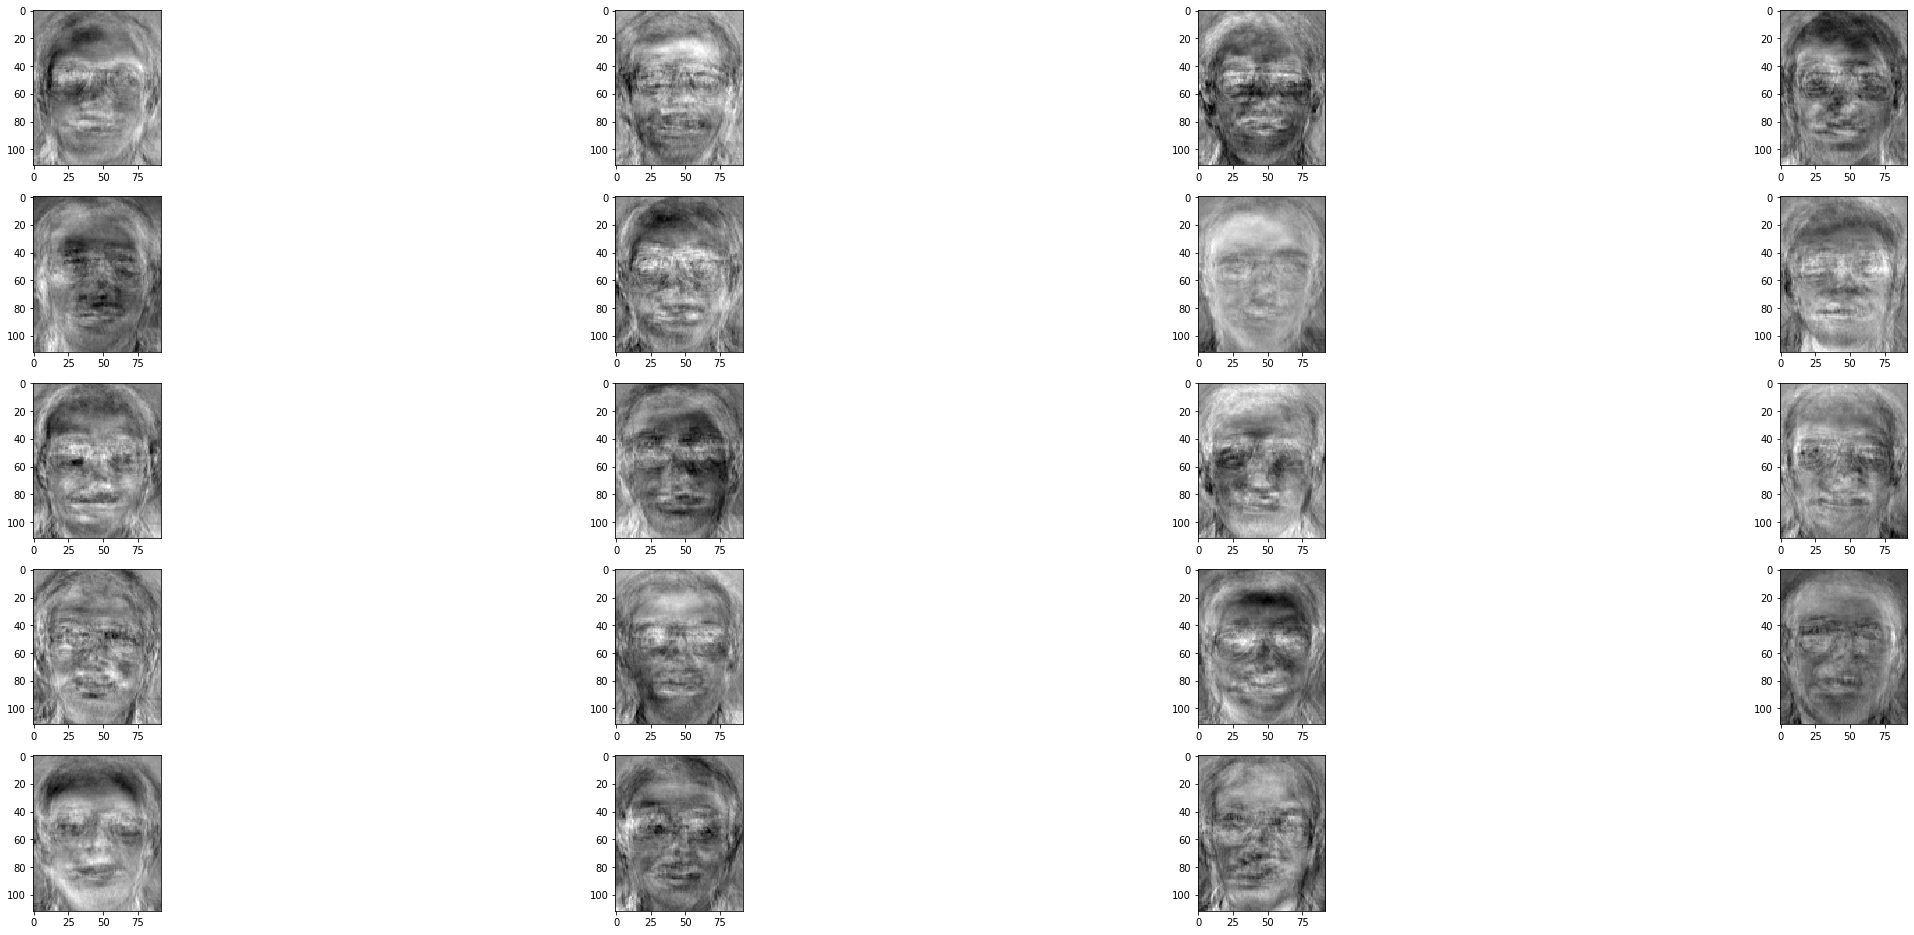

In [7]:
"""Plotting eigen faces"""
plotter(eigenFace,(chosenK//4)+1)

In [8]:
"""Predicting on test set and calculating accuracy"""
y_pred = predict(testSet2,meanImage,sigMatrix,eigenFace,7800000)
acc = calcAcc(y_pred,y_testn)
print("The accuracy of our model for k : ",chosenK," is : ",acc,"%" )

The accuracy of our model for k :  19  is :  81.3953488372093 %
